In [81]:
import os
import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (FuncFormatter)

from pprint import pprint as pp
from tqdm import tqdm

## Define Constants

In [82]:
RAW_DATA_PATH = '../data/raw'
PROCESSED_DATA_PATH = '../data/processed'
ERROR_DATA_PATH = '../data/errors'

for path in [RAW_DATA_PATH, PROCESSED_DATA_PATH, ERROR_DATA_PATH]:
    if not os.path.exists(path):
        os.makedirs(path)

In [83]:
CONFIRMED_CASES_FILE = 'CONVENIENT_us_confirmed_cases.csv'
CONFIRMED_DEATHS_FILE = 'CONVENIENT_us_deaths.csv'
CONFIRMED_CASES_RAW_FILE = 'RAW_us_confirmed_cases.csv'
MASK_USE_FILE = 'mask-use-by-county.csv'
MASK_MANDATE_FILE = 'U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv'

In [84]:
COUNTY_NAME = 'Philadelphia'
STATE_NAME = 'Pennsylvania'
STATE_NAME_ABB = 'PA'
COUNTY_NAME_MASK_MANDATE_STR = f'{COUNTY_NAME} County'

COUNTY_POPULATION = 1603797

## Process 'confirmed cases' Data

In [85]:
confirmed_cases_df = pd.read_csv(
    os.path.join(RAW_DATA_PATH, CONFIRMED_CASES_FILE), 
    low_memory=False,
    header=[0,1]
)

In [86]:
confirmed_deaths_df = pd.read_csv(
    os.path.join(RAW_DATA_PATH, CONFIRMED_DEATHS_FILE), 
    low_memory=False,
    header=[0,1]
)

In [87]:
confirmed_cases_df.head()

Province_State Alabama                                                     \
          Admin2 Autauga Baldwin Barbour Bibb Blount Bullock Butler Calhoun   
0        1/23/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   
1        1/24/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   
2        1/25/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   
3        1/26/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   
4        1/27/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   

            ... Wyoming                                                  \
  Chambers  ...    Park Platte Sheridan Sublette Sweetwater Teton Uinta   
0      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   
1      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   
2      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   
3      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   
4      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   

                              
  Unassigned Washakie Weston  
0        0.0      0.0    0.0  
1        0.0      0.0    0.0  
2        0.0      0.0    0.0  
3        0.0      0.0    0.0  
4        0.0      0.0    0.0  

[5 rows x 3343 columns]

In [88]:
confirmed_deaths_df.head()

Province_State Alabama                                                     \
          Admin2 Autauga Baldwin Barbour Bibb Blount Bullock Butler Calhoun   
0        1/23/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   
1        1/24/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   
2        1/25/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   
3        1/26/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   
4        1/27/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   

            ... Wyoming                                                  \
  Chambers  ...    Park Platte Sheridan Sublette Sweetwater Teton Uinta   
0      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   
1      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   
2      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   
3      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   
4      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   

                              
  Unassigned Washakie Weston  
0        0.0      0.0    0.0  
1        0.0      0.0    0.0  
2        0.0      0.0    0.0  
3        0.0      0.0    0.0  
4        0.0      0.0    0.0  

[5 rows x 3343 columns]

In [89]:
philly_cases_df = pd.DataFrame((confirmed_cases_df['Province_State']['Admin2']).copy())
philly_cases_df['Cases'] = (confirmed_cases_df[STATE_NAME][COUNTY_NAME]).copy()

philly_cases_df.rename(
    columns={"Admin2": "Date"},
    inplace=True
)

philly_cases_df['Date']= pd.to_datetime(philly_cases_df['Date'])

# Keep data only for the daterange we want:  February 1, 2020 through October 15, 2021
mask = (philly_cases_df['Date'] >= '2020-2-1') & (philly_cases_df['Date'] <= '2021-10-15')
philly_cases_df = philly_cases_df.loc[mask]

philly_cases_df['Cases Moving Average'] = philly_cases_df.Cases.rolling(window=7).mean().round()
philly_cases_df['Cases Cumulative'] = philly_cases_df['Cases'].cumsum()

philly_cases_df.head()

,Date,Cases,Cases Moving Average,Cases Cumulative
9,2020-02-01,0.0,NaN,0.0
10,2020-02-02,0.0,NaN,0.0
11,2020-02-03,0.0,NaN,0.0
12,2020-02-04,0.0,NaN,0.0
13,2020-02-05,0.0,NaN,0.0


In [90]:
philly_deaths_df = pd.DataFrame((confirmed_deaths_df['Province_State']['Admin2']).copy())
philly_deaths_df['Deaths'] = (confirmed_deaths_df[STATE_NAME][COUNTY_NAME]).copy()

philly_deaths_df.rename(
    columns={"Admin2": "Date"},
    inplace=True
)

philly_deaths_df['Date']= pd.to_datetime(philly_deaths_df['Date'])

# Keep data only for the daterange we want:  February 1, 2020 through October 15, 2021
mask = (philly_deaths_df['Date'] >= '2020-2-1') & (philly_deaths_df['Date'] <= '2021-10-15')
philly_deaths_df = philly_deaths_df.loc[mask]

philly_deaths_df['Deaths Moving Average'] = philly_deaths_df.Deaths.rolling(window=7).mean().round()
philly_deaths_df['Deaths Cumulative'] = philly_deaths_df['Deaths'].cumsum()

philly_deaths_df.head()

,Date,Deaths,Deaths Moving Average,Deaths Cumulative
9,2020-02-01,0.0,NaN,0.0
10,2020-02-02,0.0,NaN,0.0
11,2020-02-03,0.0,NaN,0.0
12,2020-02-04,0.0,NaN,0.0
13,2020-02-05,0.0,NaN,0.0


In [91]:
philly_cases_df = pd.merge(philly_cases_df, philly_deaths_df, 
                           how='left', on='Date'
)

philly_cases_df['Initial Population'] = COUNTY_POPULATION
philly_cases_df['Susceptible Population'] = philly_cases_df['Initial Population'] - philly_cases_df['Deaths Cumulative'] - philly_cases_df['Cases Cumulative']

philly_cases_df['Rate of Infection'] = (philly_cases_df['Cases Cumulative'] / philly_cases_df['Susceptible Population']) * 100

In [92]:
philly_cases_df.head()

,Date,Cases,Cases Moving Average,Cases Cumulative,Deaths,Deaths Moving Average,Deaths Cumulative,Initial Population,Susceptible Population,Rate of Infection
0,2020-02-01,0.0,NaN,0.0,0.0,NaN,0.0,1603797,1603797.0,0.0
1,2020-02-02,0.0,NaN,0.0,0.0,NaN,0.0,1603797,1603797.0,0.0
2,2020-02-03,0.0,NaN,0.0,0.0,NaN,0.0,1603797,1603797.0,0.0
3,2020-02-04,0.0,NaN,0.0,0.0,NaN,0.0,1603797,1603797.0,0.0
4,2020-02-05,0.0,NaN,0.0,0.0,NaN,0.0,1603797,1603797.0,0.0


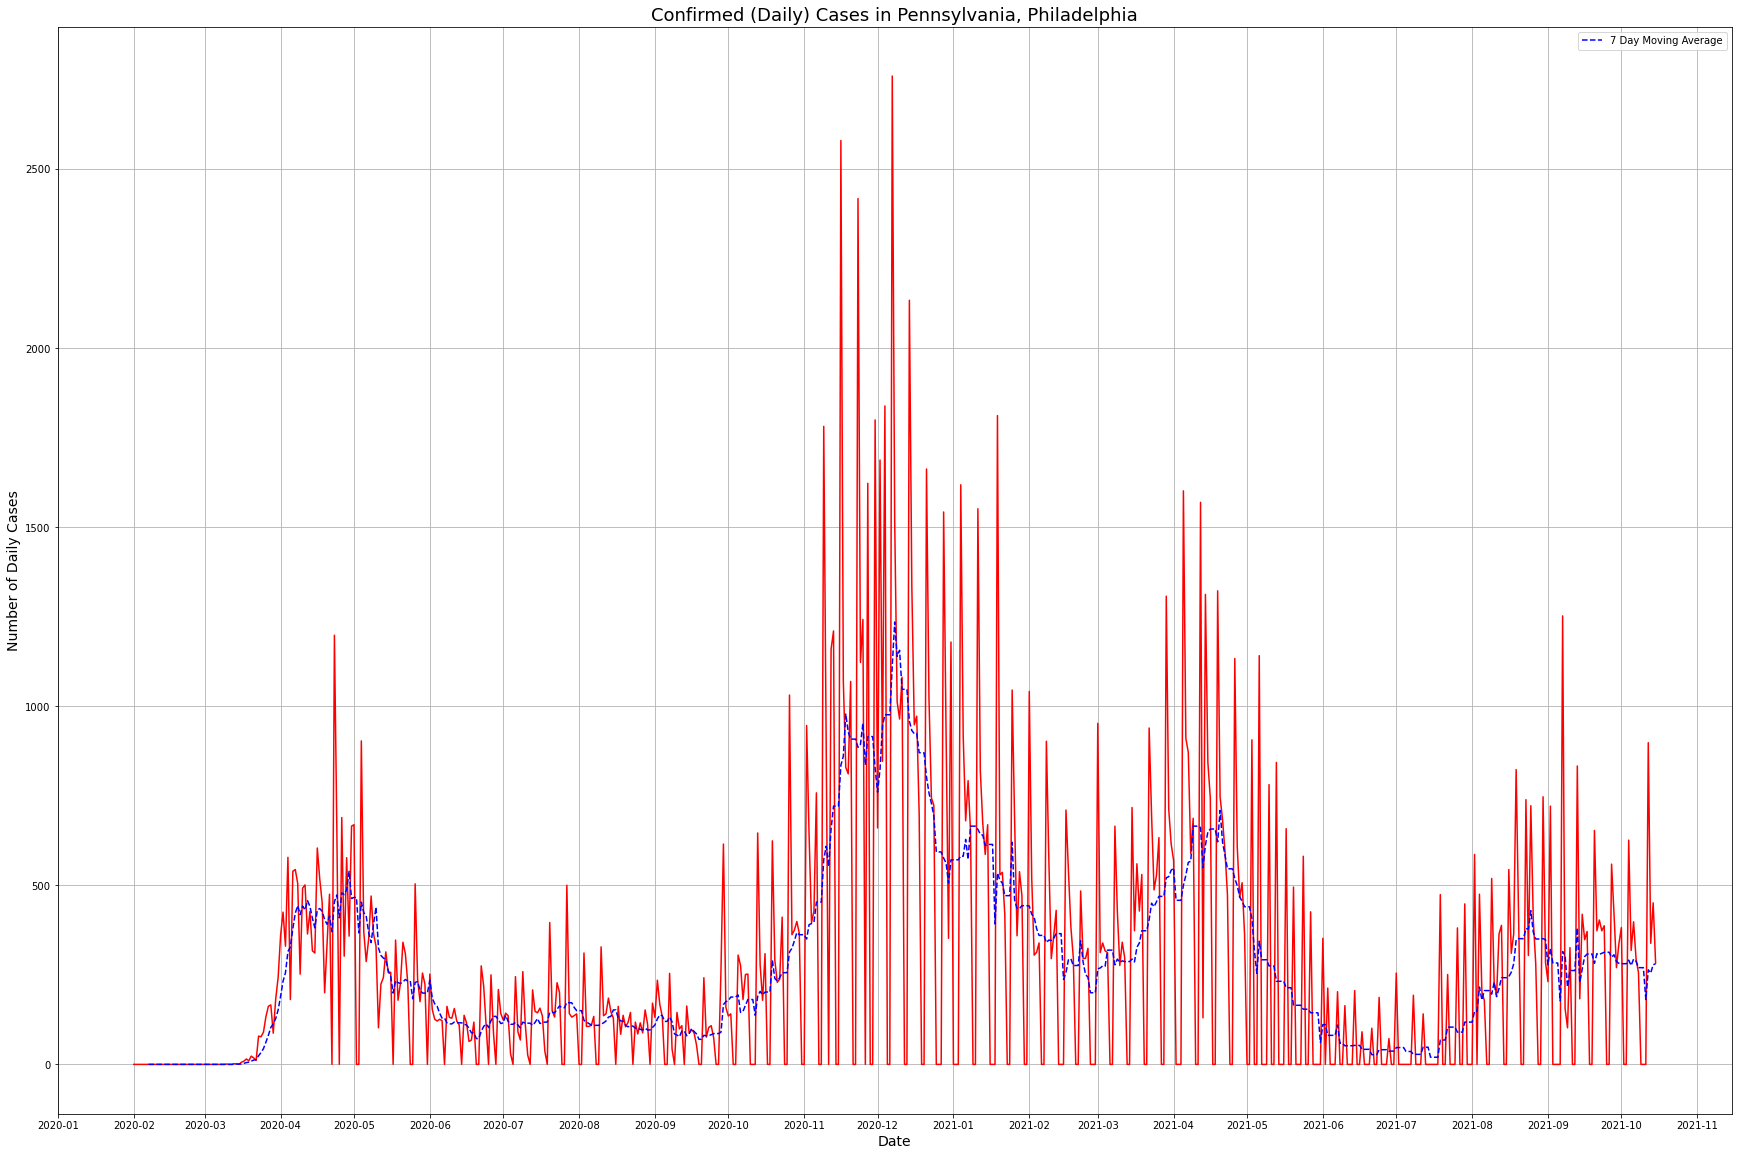

In [93]:
plt.figure(figsize=(30,20))
ax = plt.gca()
# ax2 = ax.twinx()

# Create lines and choose characteristics
ax.plot('Date', 'Cases', 'r', data=philly_cases_df, label='')
ax.plot('Date', 'Cases Moving Average', 'b--', data=philly_cases_df, label='7 Day Moving Average')

# format the x-ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)
# ax.xaxis.set_minor_locator(months)

# Add title and axis names
plt.title(f'Confirmed (Daily) Cases in {STATE_NAME}, {COUNTY_NAME}', fontsize=18)
plt.xlabel('Date', fontsize=14)
ax.set_ylabel('Number of Daily Cases', fontsize=14)
# ax2.set_ylabel('Number of Deaths', fontsize=14)

plt.grid()
ax.legend()

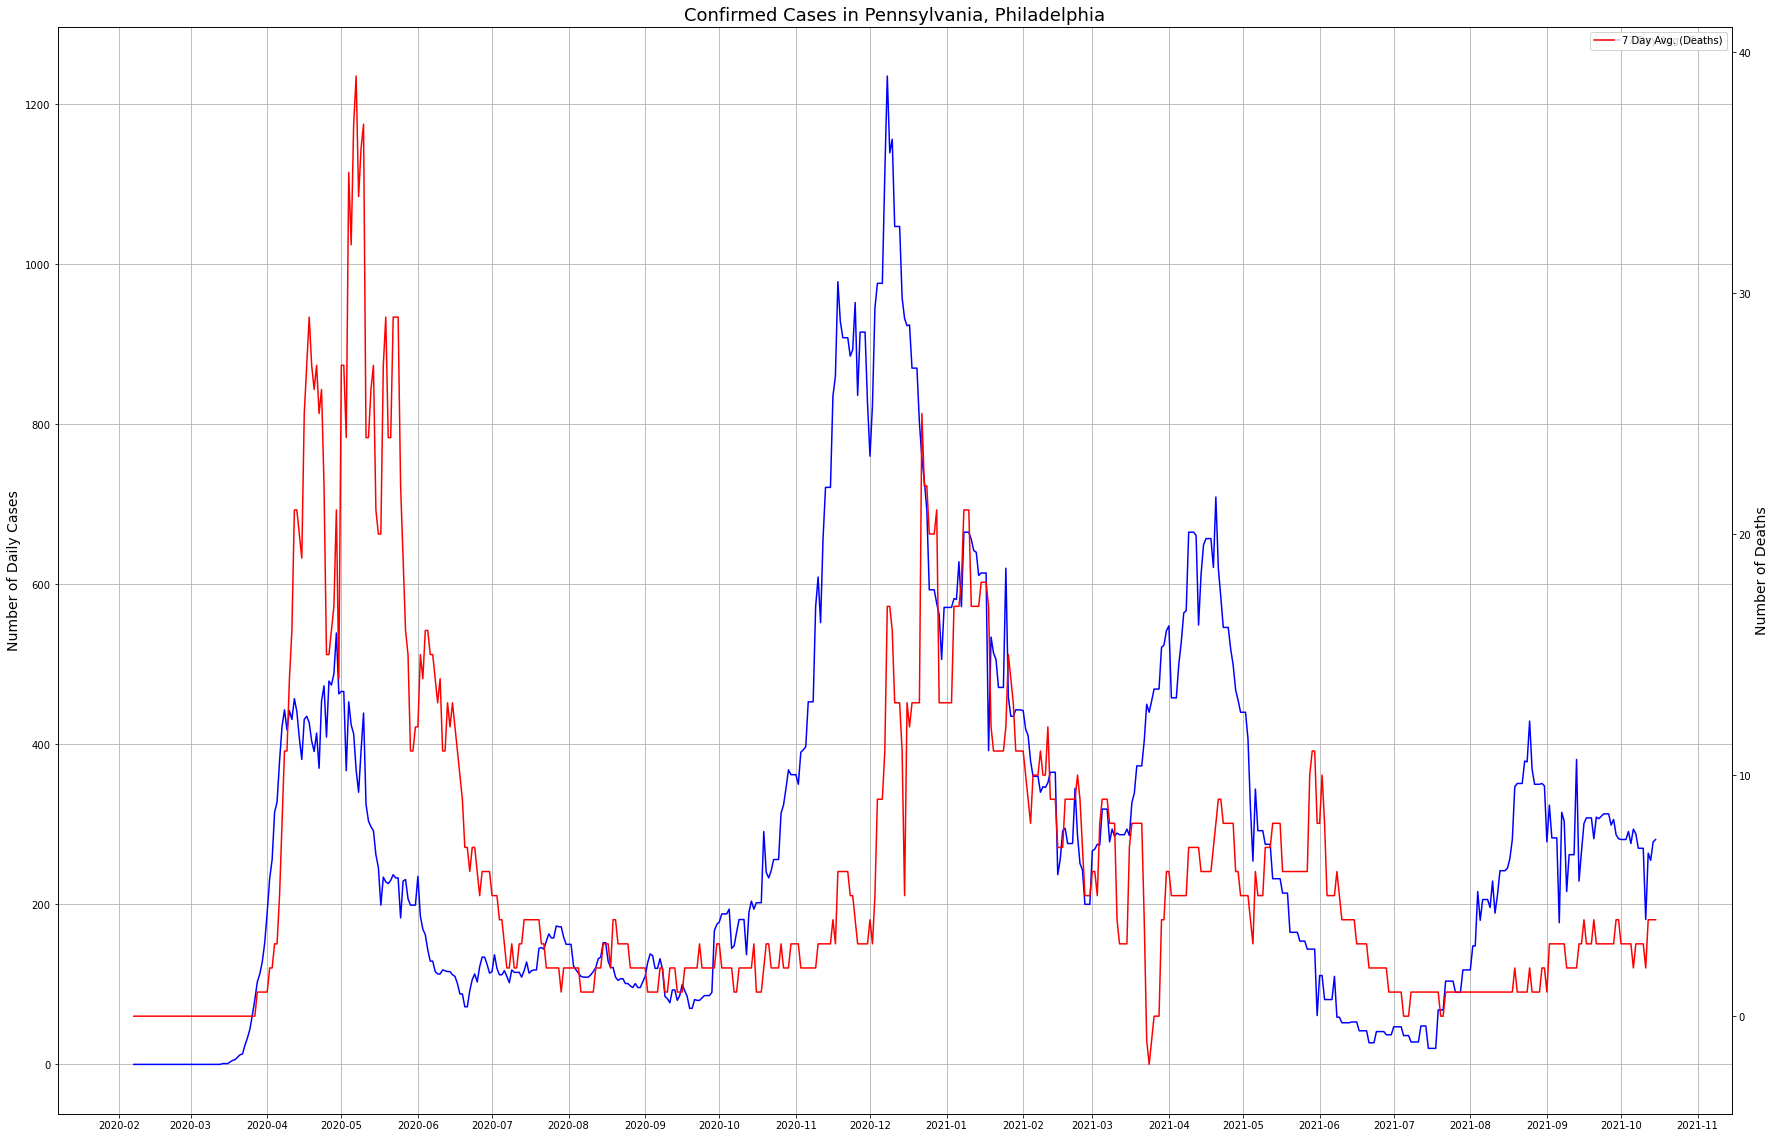

In [94]:
plt.figure(figsize=(30,20))
ax = plt.gca()
ax2 = ax.twinx()

# Create lines and choose characteristics
ax.plot('Date', 'Cases Moving Average', 'b', data=philly_cases_df, label='7 Day Avg. (Cases)')
ax2.plot('Date', 'Deaths Moving Average', 'r', data=philly_cases_df, label='7 Day Avg. (Deaths)')

# format the x-ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)
# ax.xaxis.set_minor_locator(months)

# Add title and axis names
plt.title(f'Confirmed Cases in {STATE_NAME}, {COUNTY_NAME}', fontsize=18)
plt.xlabel('Date', fontsize=14)
ax.set_ylabel('Number of Daily Cases', fontsize=14)
ax2.set_ylabel('Number of Deaths', fontsize=14)

ax.grid()
ax.legend()
ax2.legend()

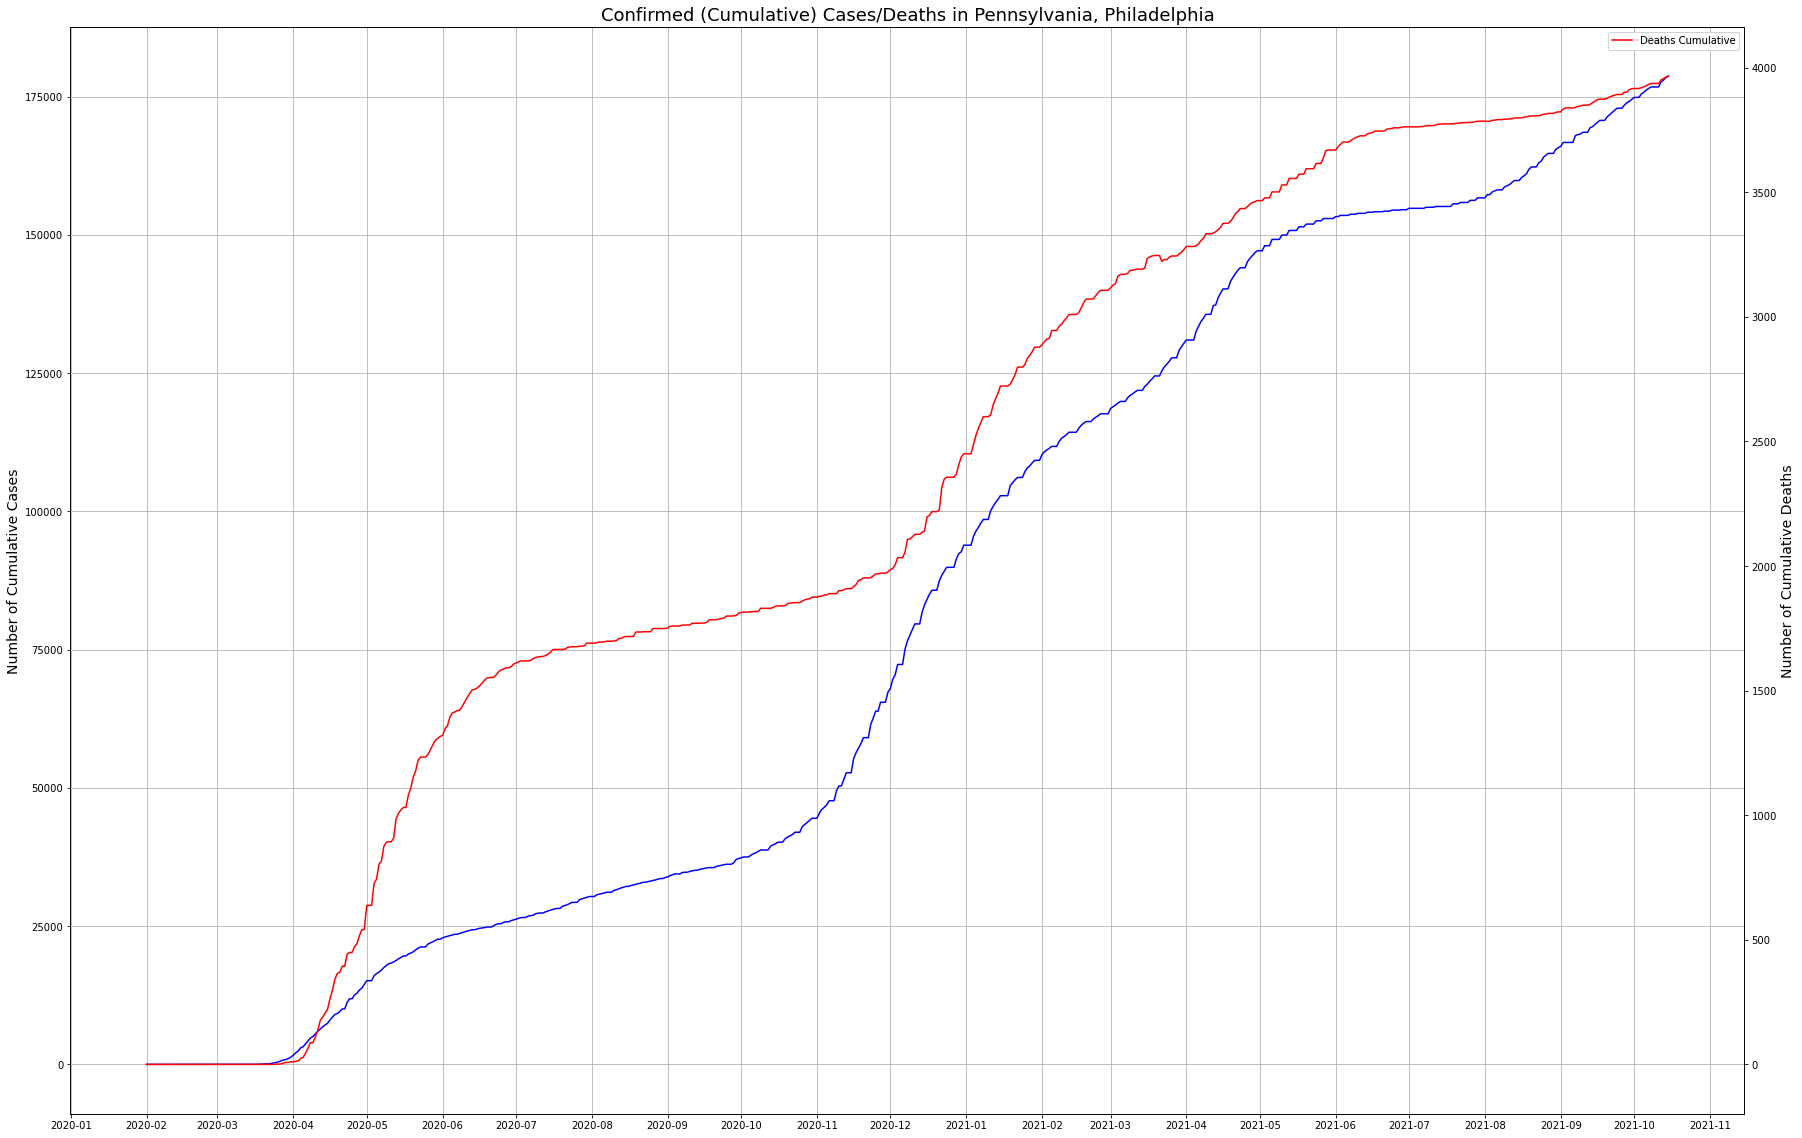

In [95]:
plt.figure(figsize=(30,20))
ax = plt.gca()
ax2 = ax.twinx()

# Create lines and choose characteristics
ax.plot('Date', 'Cases Cumulative', 'b', data=philly_cases_df, label='Cases Cumulative')
ax2.plot('Date', 'Deaths Cumulative', 'r', data=philly_cases_df, label='Deaths Cumulative')

# format the x-ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)
# ax.xaxis.set_minor_locator(months)

# Add title and axis names
plt.title(f'Confirmed (Cumulative) Cases/Deaths in {STATE_NAME}, {COUNTY_NAME}', fontsize=18)
plt.xlabel('Date', fontsize=14)
ax.set_ylabel('Number of Cumulative Cases', fontsize=14)
ax2.set_ylabel('Number of Cumulative Deaths', fontsize=14)

ax.grid()
ax.legend()
ax2.legend()

## Process 'mask mandates' Data

In [96]:
mask_mandate_df = pd.read_csv(
    os.path.join(RAW_DATA_PATH, MASK_MANDATE_FILE)
)

In [97]:
mask_mandate_df.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
0,AL,Autauga County,1,1,4/10/2020,2,NaN,NaN,NaN,NaN
1,AL,Autauga County,1,1,4/11/2020,2,NaN,NaN,NaN,NaN
2,AL,Autauga County,1,1,4/12/2020,2,NaN,NaN,NaN,NaN
3,AL,Autauga County,1,1,4/13/2020,2,NaN,NaN,NaN,NaN
4,AL,Autauga County,1,1,4/14/2020,2,NaN,NaN,NaN,NaN


In [98]:
philly_mask_mandate_df = (mask_mandate_df.loc[
    (mask_mandate_df['State_Tribe_Territory']==STATE_NAME_ABB) &\
    (mask_mandate_df['County_Name']==COUNTY_NAME_MASK_MANDATE_STR)
]).copy()

philly_mask_mandate_df['date'] = pd.to_datetime(philly_mask_mandate_df['date'])

mask = (philly_mask_mandate_df['date'] >= '2020-2-1') & (philly_mask_mandate_df['date'] <= '2021-10-15')
philly_mask_mandate_df = philly_mask_mandate_df.loc[mask]

# drop rows where the rows are N/A
# philly_mask_mandate_df.dropna(
#     subset=['Face_Masks_Required_in_Public'],
#     inplace=True
# )

philly_mask_mandate_df[['Face_Masks_Required_in_Public_Embedded']] = philly_mask_mandate_df[['Face_Masks_Required_in_Public']].replace(
    {"Yes": 1, "No": 0}
)

In [99]:
philly_mask_mandate_df.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation,Face_Masks_Required_in_Public_Embedded
610213,PA,Philadelphia County,42,101,2020-04-10,2,NaN,NaN,NaN,NaN,NaN
610214,PA,Philadelphia County,42,101,2020-04-11,2,NaN,NaN,NaN,NaN,NaN
610215,PA,Philadelphia County,42,101,2020-04-12,2,NaN,NaN,NaN,NaN,NaN
610216,PA,Philadelphia County,42,101,2020-04-13,2,NaN,NaN,NaN,NaN,NaN
610217,PA,Philadelphia County,42,101,2020-04-14,2,NaN,NaN,NaN,NaN,NaN


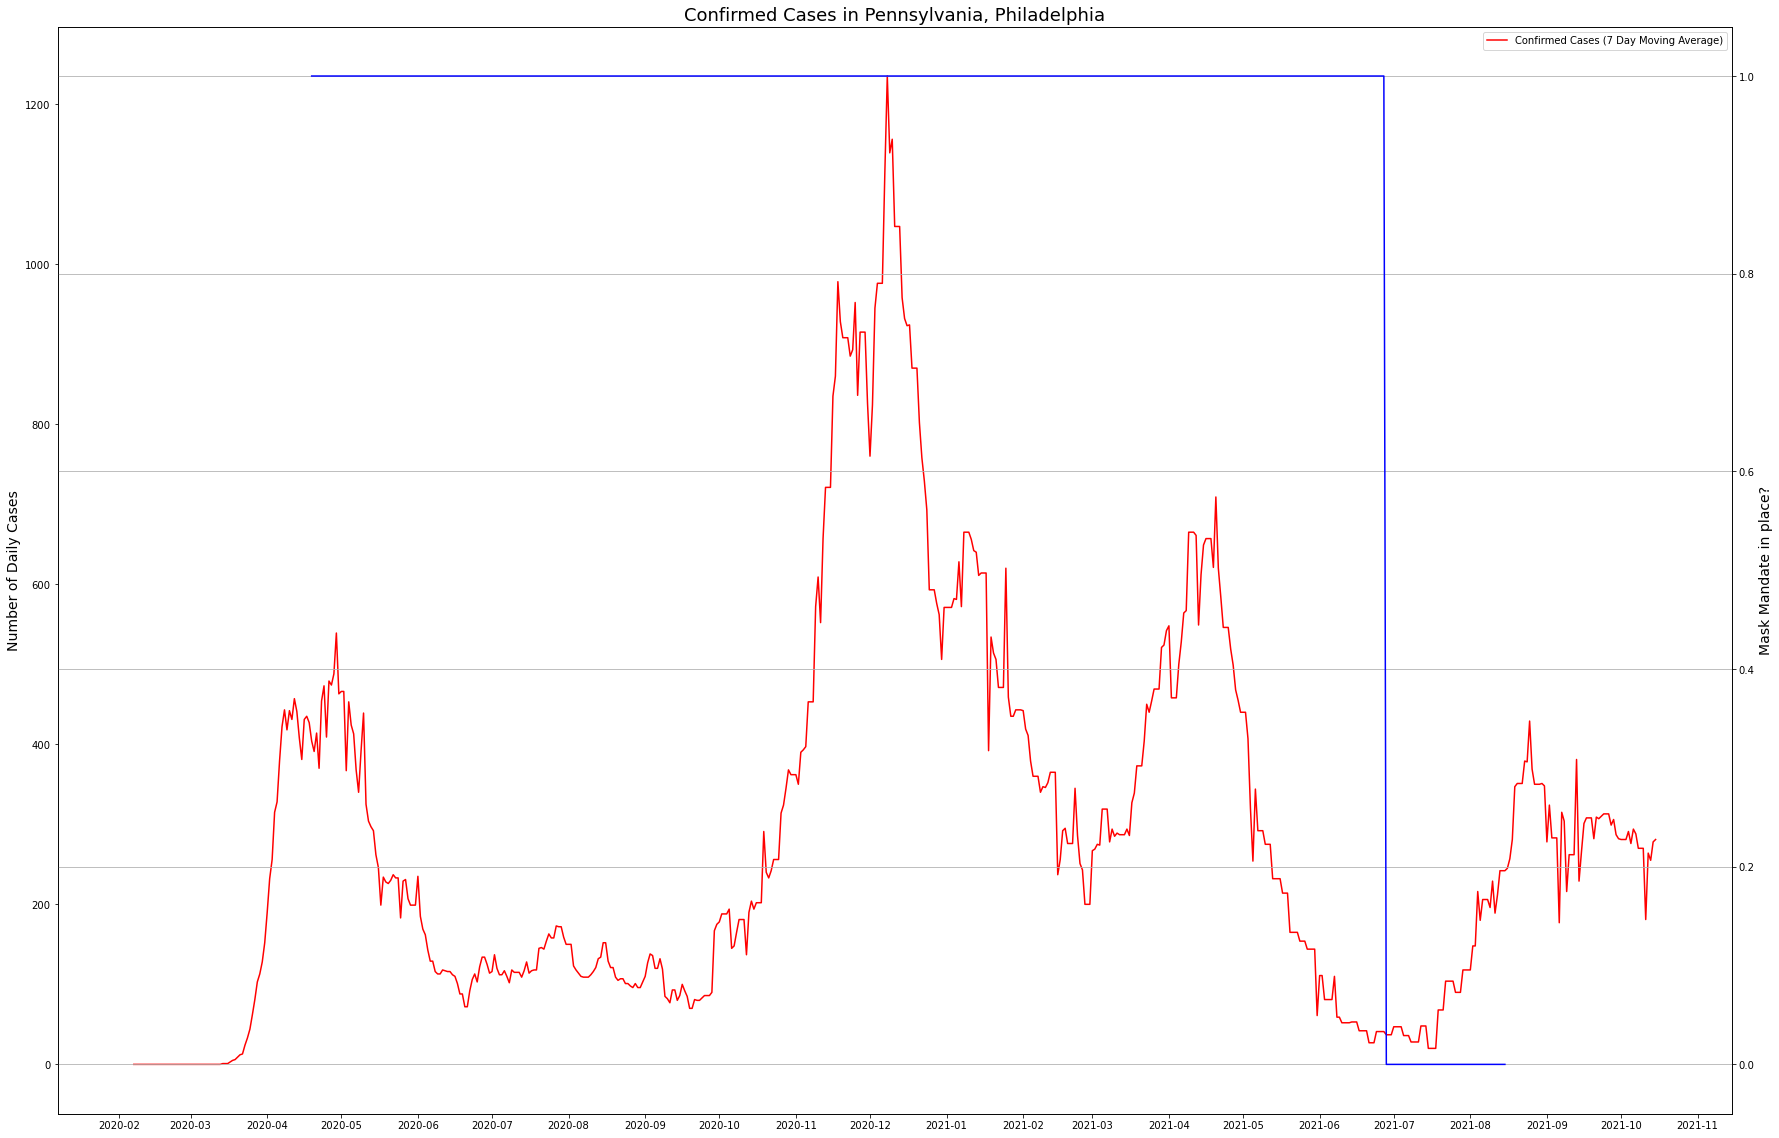

In [100]:
plt.figure(figsize=(30,20))
ax = plt.gca()
ax2 = ax.twinx()

# Create lines and choose characteristics
ax.plot('Date', 'Cases Moving Average', 'r', data=philly_cases_df, label='Confirmed Cases (7 Day Moving Average)')
ax2.plot('date', 'Face_Masks_Required_in_Public_Embedded', 'b', data=philly_mask_mandate_df, label='Is Mask Policy in Effect?')

# format the x-ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)
# ax.xaxis.set_minor_locator(months)

# Add title and axis names
plt.title(f'Confirmed Cases in {STATE_NAME}, {COUNTY_NAME}', fontsize=18)
plt.xlabel('Date', fontsize=14)
ax.set_ylabel('Number of Daily Cases', fontsize=14)
ax2.set_ylabel('Mask Mandate in place?', fontsize=14)

plt.grid()
ax.legend()

In [101]:
philly_combined_df = pd.merge(philly_cases_df, philly_mask_mandate_df, how='left', left_on='Date', right_on='date')
philly_combined_df[['Face_Masks_Required_in_Public_Color']] = philly_combined_df[['Face_Masks_Required_in_Public']].replace(
    {"Yes": 'blue', "No": 'red', np.nan: 'green'}
)

philly_combined_df = philly_combined_df[
    ['Date',
     'Cases', 'Cases Moving Average', 'Cases Cumulative',
     'Deaths', 'Deaths Moving Average', 'Deaths Cumulative',
     'Face_Masks_Required_in_Public_Color',
     'Rate of Infection'
    ]
]

In [102]:
MANDATE_DATE_END = datetime.datetime(2021, 6, 27)
MANDATE_DATE_START = datetime.datetime(2020, 4, 19)

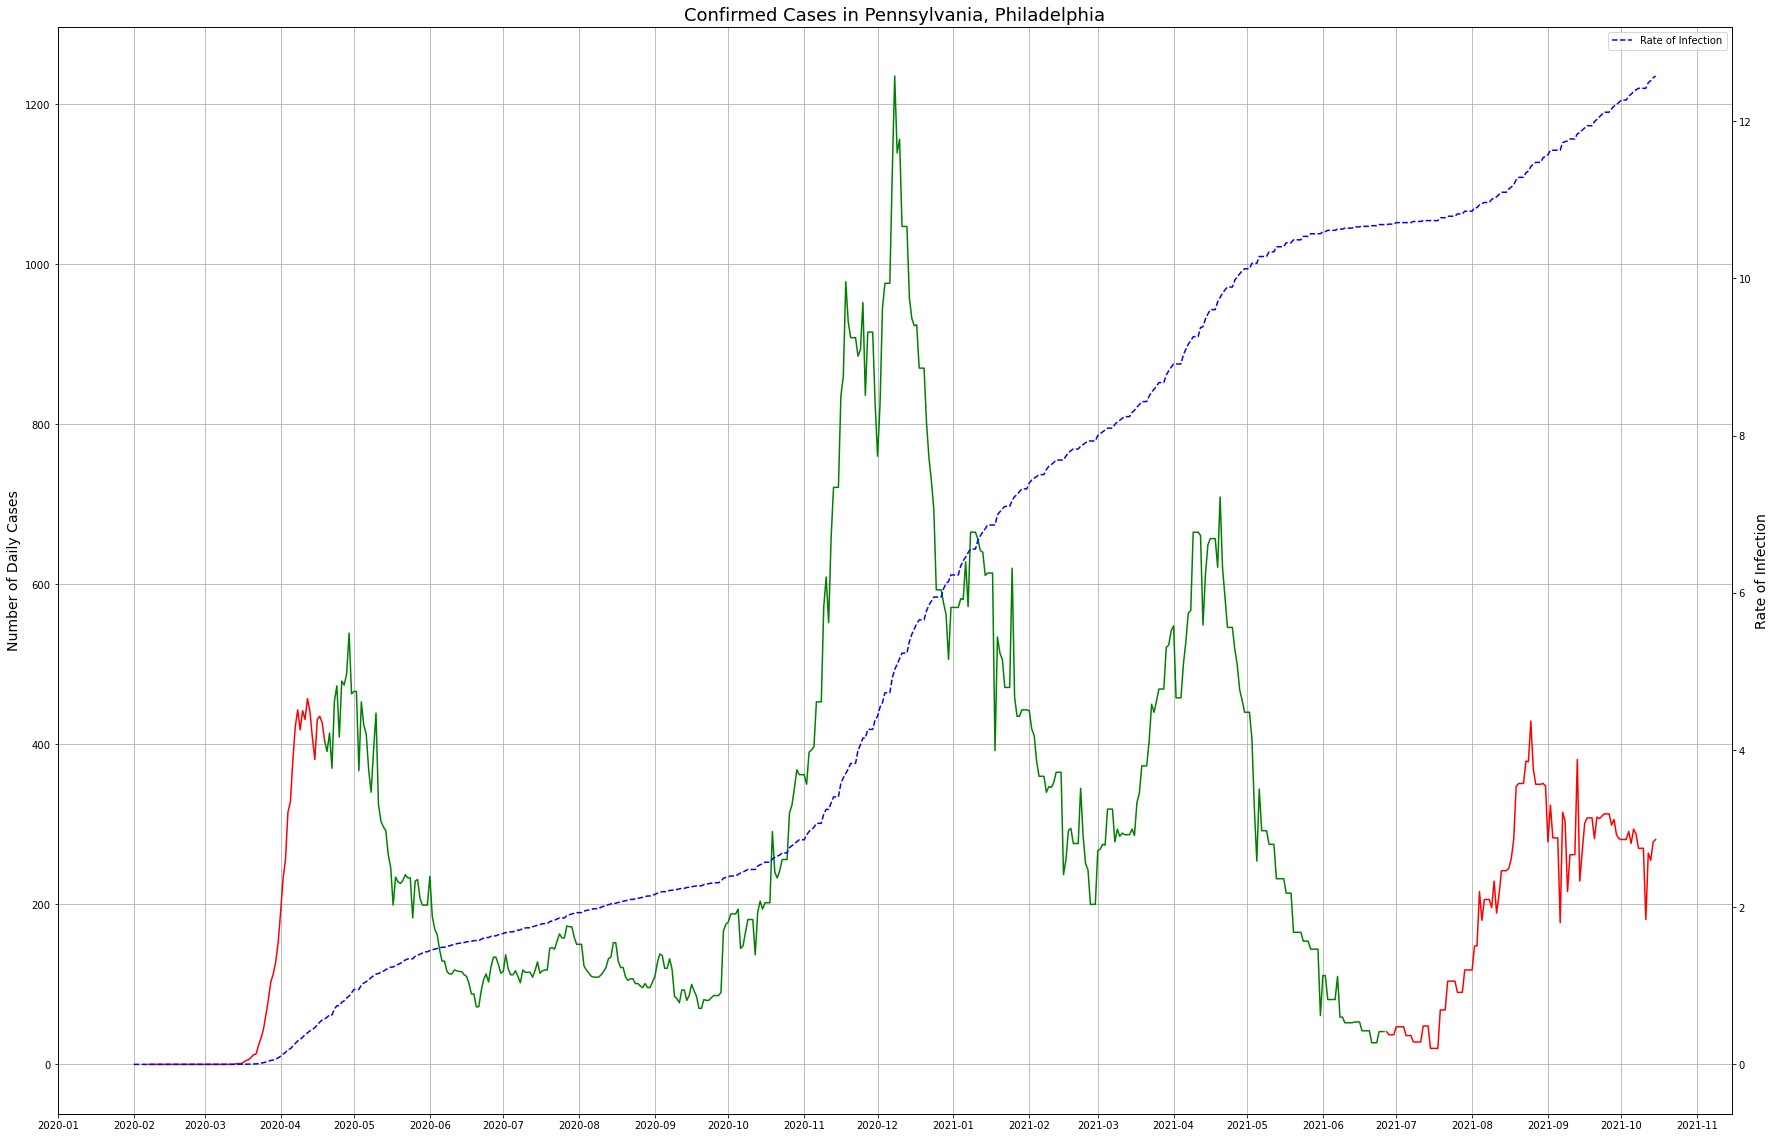

In [106]:
mask_enforced_philly_combined_df = philly_combined_df.loc[(philly_combined_df['Date'] >= MANDATE_DATE_START) & (philly_combined_df['Date'] < MANDATE_DATE_END)]
pre_mask_enforced_philly_combined_df = philly_combined_df.loc[(philly_combined_df['Date'] <= MANDATE_DATE_START)]
post_mask_enforced_philly_combined_df = philly_combined_df.loc[(philly_combined_df['Date'] >= MANDATE_DATE_END)]

plt.figure(figsize=(30,20))
ax = plt.gca()
ax2 = ax.twinx()

# Create lines and choose characteristics
ax.plot('Date', 'Cases Moving Average', 'g', data=mask_enforced_philly_combined_df, label='Mask Mandate Enforced')
ax.plot('Date', 'Cases Moving Average', 'r', data=pre_mask_enforced_philly_combined_df, label='Mask Mandate Lifted')
ax.plot('Date', 'Cases Moving Average', 'r', data=post_mask_enforced_philly_combined_df, label='')
ax2.plot('Date', 'Rate of Infection', 'b--', data=philly_combined_df, label='Rate of Infection')

# format the x-ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)
# ax.xaxis.set_minor_locator(months)

# Add title and axis names
plt.title(f'Confirmed Cases in {STATE_NAME}, {COUNTY_NAME}', fontsize=18)
plt.xlabel('Date', fontsize=14)
ax.set_ylabel('Number of Daily Cases', fontsize=14)
ax2.set_ylabel('Rate of Infection', fontsize=14)

ax.grid()
plt.legend()

## M

In [104]:
mask_usage_df = pd.read_csv(
    os.path.join(RAW_DATA_PATH, MASK_USE_FILE)
)

In [105]:
mask_usage_df.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459
